# Introduction

Computer vision is used to improve the lives of unsuspecting humans everyday. Object recognition software continues to be utilized more and more in all aspects of life as training models and overall accuracy improves. The goal of this project is to highlight the differences in performance between common models utilized in the field of computer vision. 

One particular utilization of computer vision that’s seen much publicity in recent years is that of self driving vehicles. At the very base level of this complex problem is the ability to recognize hazards in real time. With this in mind, our model will be trained on a plethora of images that includes cars, boats, and neither, with the end goal of improving overall accuracy in determining which of the three categories any particular image belongs to.

In [1]:
%autosave 600
%matplotlib inline

Autosaving every 600 seconds


# Imports

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import random
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from PIL import Image
from natsort import natsorted
import random
from PIL import Image
import igraph
import cv2
import os
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.ensemble import RandomForestClassifier


c:\users\mattk\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Data preprocessing and visualization

In [3]:
'''
#resize all boats
#empty lists
image_list = []
resized_images = []
for filename in natsorted(glob.glob("captcha/*.png")):
    img = Image.open(filename)
    image_list.append(img)
    
for image in image_list:
    image = image.resize((64,64))
    resized_images.append(image)
    
for (i, new) in enumerate(resized_images):
    new.save('{} {} {}'.format('captcha_f/', i+1, '.png'))   
    '''

'\n#resize all boats\n#empty lists\nimage_list = []\nresized_images = []\nfor filename in natsorted(glob.glob("captcha/*.png")):\n    img = Image.open(filename)\n    image_list.append(img)\n    \nfor image in image_list:\n    image = image.resize((64,64))\n    resized_images.append(image)\n    \nfor (i, new) in enumerate(resized_images):\n    new.save(\'{} {} {}\'.format(\'captcha_f/\', i+1, \'.png\'))   \n    '

In [4]:
# Paths
dir_ = Path('data')
filepaths = list(dir_.glob(r'**/*.*'))

# Labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)


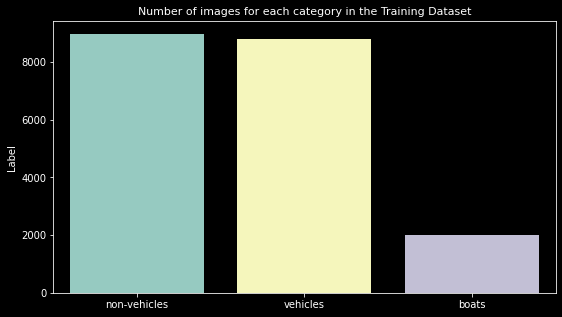

In [5]:
plt.style.use("dark_background")

# Look at data volume

vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

Text(0.5, 1.0, 'vehicles')

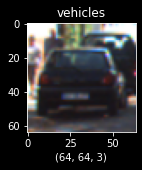

In [6]:
# Preview some images

figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'boats')

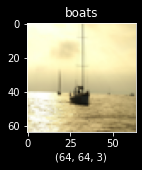

In [7]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][105])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][105])

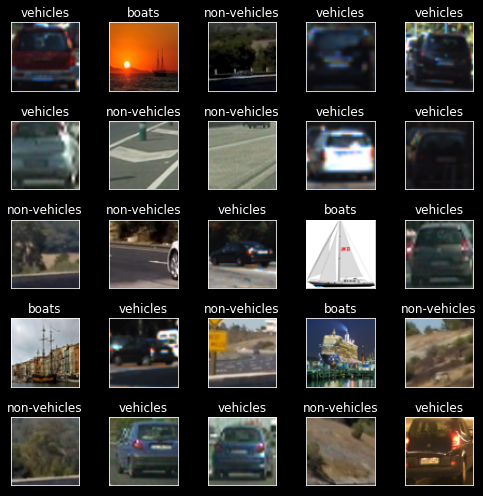

In [8]:
# Show more images in a grid format

fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

## PCA and T-SNE for dimensionality reduction and data visualization

In [9]:
#Code to grab 600/19,733 photos we have and store them in a data vector. We have to do this because we have way more
# vehicle/non-vehicle photos than boat photos so this will make the output visual look much better. (200 boat/veh/non-veh)
data = []
folder = 'data_subset/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])

100%|███████████████████████████████████████████████████████████████████████████████| 602/602 [00:01<00:00, 506.62it/s]


In [10]:
#Store the features of each image and location of image into two variables so we can run pca and t-sne and eventually get the 
# original images back to make a visual
features, images  = zip(*data)

In [11]:
#instantiate and apply pca
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [12]:
#instantiate and apply t-sne from the pca dimensionality reduction
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=500, perplexity=35, angle=0.3, verbose=2).fit_transform(X)

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 602 samples in 0.000s...
[t-SNE] Computed neighbors for 602 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 602 / 602
[t-SNE] Mean sigma: 631.444648
[t-SNE] Computed conditional probabilities in 0.064s
[t-SNE] Iteration 50: error = 83.2646027, gradient norm = 0.2683722 (50 iterations in 0.091s)
[t-SNE] Iteration 100: error = 85.6585236, gradient norm = 0.2515776 (50 iterations in 0.093s)
[t-SNE] Iteration 150: error = 86.9377441, gradient norm = 0.2502526 (50 iterations in 0.092s)
[t-SNE] Iteration 200: error = 82.4693985, gradient norm = 0.2806291 (50 iterations in 0.089s)
[t-SNE] Iteration 250: error = 83.6368637, gradient norm = 0.2622309 (50 iterations in 0.097s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.636864
[t-SNE] Iteration 300: error = 1.2052176, gradient norm = 0.0067498 (50 iterations in 0.093s)
[t-SNE] Iteration 350: error = 1.0344056, gradient norm = 0.003519

In [13]:
#normalise the embedding of the images between [0,1]
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

<ipython-input-14-583511a76fa8>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


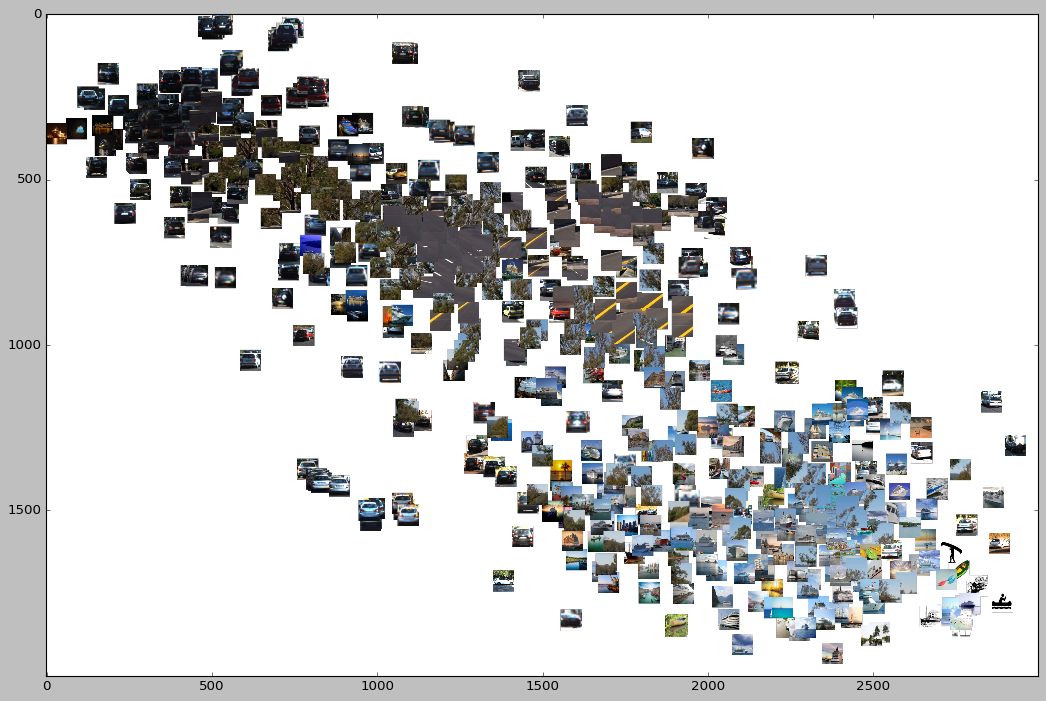

In [14]:
# Compose new RGB image that have been ordered by components of the t-sne results and print visual of groups
plt.style.use("classic")
width = 3000
height = 2000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
plt.figure(figsize = (16,12))
imshow(full_image)

## Start of CNN ResNet-50 model

In [15]:
filepath = 'data/'
for dirname, _, filenames in os.walk(filepath):
    print(dirname)

data/
data/boats
data/non-vehicles
data/vehicles


In [16]:
#split the data into train/test
train_datagen = ImageDataGenerator(
                fill_mode = 'nearest',
                validation_split=0.15
)

In [17]:
#set up the train and validation generators
train_generator=train_datagen.flow_from_directory(
    filepath,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
)
validation_generator=train_datagen.flow_from_directory(
    filepath,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
)

Found 16809 images belonging to 3 classes.
Found 2964 images belonging to 3 classes.


In [18]:
model = tf.keras.models.Sequential([
    ResNet50(input_shape=(108,108,3), include_top=False),
])
for layer in model.layers:
  layer.trainable = False

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [19]:
# compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# fit the model so we can display the results
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=1,
                    )

Epoch 1/20
526/526 [==============================] - 268s 506ms/step - loss: 0.1207 - accuracy: 0.9719 - val_loss: 0.1333 - val_accuracy: 0.9723
Epoch 2/20
526/526 [==============================] - 281s 534ms/step - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0335 - val_accuracy: 0.9912
Epoch 3/20
526/526 [==============================] - 270s 514ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0220 - val_accuracy: 0.9943
Epoch 4/20
526/526 [==============================] - 273s 519ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0415 - val_accuracy: 0.9943
Epoch 5/20
526/526 [==============================] - 273s 519ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 0.0451 - val_accuracy: 0.9953
Epoch 6/20
526/526 [==============================] - 278s 529ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0895 - val_accuracy: 0.9845
Epoch 7/20
526/526 [==============================] - 284s 540ms/step - loss: 0.0197 - accuracy: 0.9964 - val_loss: 0.0226 -

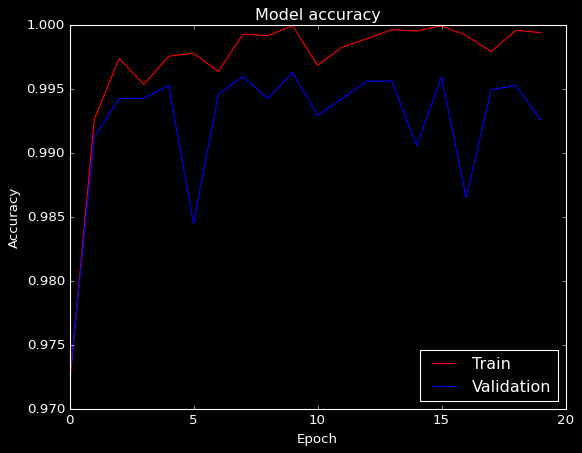

In [21]:
#Plot the models accuracy versuys epoch
plt.style.use("dark_background")
plt.plot(history.history['accuracy'], 'red')
plt.plot(history.history['val_accuracy'], 'blue')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

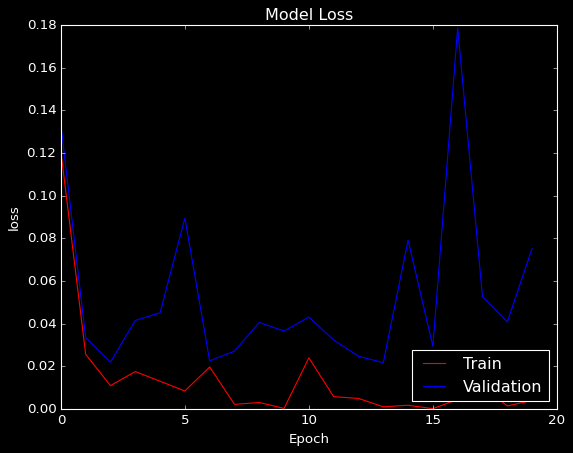

In [22]:
# Plot the models loss vs epoch
plt.plot(history.history['loss'], 'red')
plt.plot(history.history['val_loss'], 'blue')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Start of CNN INCEPTIONV3 model

In [23]:
trainset_df, testset_df = train_test_split(df, train_size = 0.90, random_state = 42)

display(trainset_df.head())

testset_df.head()

File         Label
2885            data\vehicles\4321.png      vehicles
2988   data\non-vehicles\extra2695.png  non-vehicles
19372  data\non-vehicles\extra5690.png  non-vehicles
17376  data\non-vehicles\extra1034.png  non-vehicles
3461       data\vehicles\far (357).png      vehicles

File         Label
8703    data\non-vehicles\image783.png  non-vehicles
10633           data\vehicles\3844.png      vehicles
7917   data\non-vehicles\extra5446.png  non-vehicles
6415    data\non-vehicles\image158.png  non-vehicles
15185             data\boats\1743 .png         boats

In [24]:
# converting the Label to a numeric format
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [25]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with Vehicles: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with No Vehicles: {trainset_df["Label"].value_counts()[1]}')
print(f'Number of images with Boats: {trainset_df["Label"].value_counts()[2]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with Vehicles: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with No Vehicles: {testset_df["Label"].value_counts()[1]}')
print(f'Number of images with Boats: {testset_df["Label"].value_counts()[2]}\n')

Training Dataset:
Number of images: 17795
Number of images with Vehicles: 8123
Number of images with No Vehicles: 7860
Number of images with Boats: 1812

Test Dataset:
Number of images: 1978
Number of images with Vehicles: 932
Number of images with No Vehicles: 845
Number of images with Boats: 201



rescale - Transform image size (normalization of data)

shear_range - Random geometric transformations

zoom_range - Images that will be zoomed

rotation_range - Degree of image rotation

width_shift_range - Image Width Change Range

height_shift_range - Image height change range

horizontal_flip - Rotate images horizontally

vertical_flip - Rotate images vertically

validation_split - Images that have been reserved for validation (0-1)

In [26]:
# Modifies the images for the model

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

dataframe - Dataframe containing the images directory

x_col - Column name containing the images directory

y_col - Name of the column containing what we want to predict

target_size - size of the images

color_mode - RGB color standard

class_mode - categorical class mode (boat/non-vehicle/vehicle)

batch_size - batch size (32)

shuffle - Shuffle the data

seed - optional random seed for the shuffle

subset - Subset of data being training and validation

In [27]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 16016 validated image filenames belonging to 3 classes.
Preparing the validation dataset ...
Found 1779 validated image filenames belonging to 3 classes.
Preparing the test dataset ...
Found 1978 validated image filenames belonging to 3 classes.
Data generators are ready!


In [28]:
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

input_shape - Setting the height/width and RGB channels (75, 75, 3)

include_top - Fully connected layer will not be included on top

weights - Pre-training using imagenet

In [29]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

for layer in CNN_base_inc.layers:
    layer.trainable = False
    
#Transforming the matrix to a vector to enter the Neural Network layer
x = layers.Flatten()(CNN_base_inc.output)

Dense - All connected neurons

units - Number of nodes in layer

activation - Activation function that will be inserted

Dropout - is used to decrease the chance of overfitting

In [30]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(3, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

In [31]:
# Compilation
# Use adam optimizer. Goog general purpose that changes learning rate as it goes. 
# categorical crossentropy loss function b/c 3+ classes
CNN_inc.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 20, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/20
501/501 [==============================] - 59s 113ms/step - loss: 0.2316 - accuracy: 0.9156 - val_loss: 0.1537 - val_accuracy: 0.9415
Epoch 2/20
501/501 [==============================] - 65s 129ms/step - loss: 0.1636 - accuracy: 0.9413 - val_loss: 0.1263 - val_accuracy: 0.9562
Epoch 3/20
501/501 [==============================] - 66s 131ms/step - loss: 0.1355 - accuracy: 0.9520 - val_loss: 0.1289 - val_accuracy: 0.9573
Epoch 4/20
501/501 [==============================] - 65s 129ms/step - loss: 0.1299 - accuracy: 0.9539 - val_loss: 0.1199 - val_accuracy: 0.9584
Epoch 5/20
501/501 [==============================] - 63s 126ms/step - loss: 0.1216 - accuracy: 0.9571 - val_loss: 0.1314 - val_accuracy: 0.9517
Epoch 6/20
501/501 [==============================] - 60s 120ms/step - loss: 0.1154 - accuracy: 0.9577 - val_loss: 0.0798 - val_accuracy: 0.9696
Epoch 7/20
501/501 [==============================] - 68s 135ms/step - loss: 0.1163 - accuracy: 0.9595 - val_loss: 0.1168 - val_ac

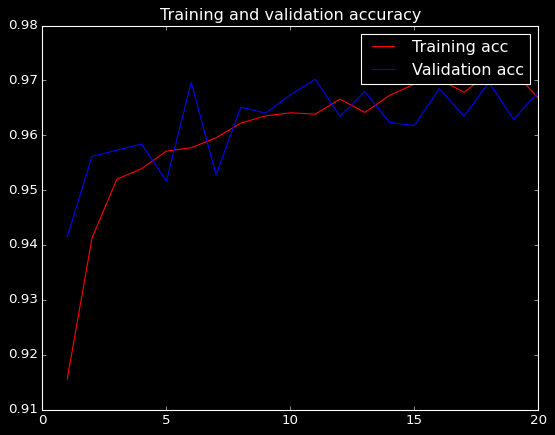

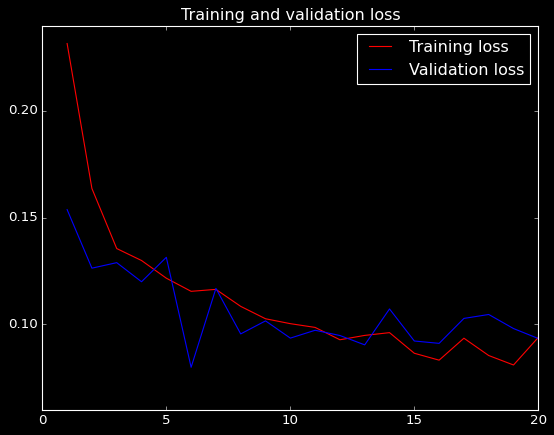

In [32]:
# Plot the improvement in accuracy and loss across epochs

acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [33]:
# Display some test set images and the model's predictions

y_pred_inc = CNN_inc.predict(test_set)


plt.style.use("dark_background")
fig, axes = plt.subplots(nrows = 5,
                         ncols = 5,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    
    
    largest = 0
    val = y_pred_inc[i][0]
    
    if y_pred_inc[i][1] > val:
        val = y_pred_inc[i][1]
        largest = 1
    if y_pred_inc[i][2] > val:
        val = y_pred_inc[i][2]
        largest = 2
        
    if largest == 0:
        output = "boats"
    elif largest == 1:
        output = "non-vehicles"
    elif largest == 2:
        output = "vehicles"
    else: 
        print("Error")
        
        
    ax.set_title(f"True Value: {testset_df.Label.iloc[i]}\nPrediction: {output}")
plt.tight_layout()
plt.show()

62/62 [==============================] - 8s 109ms/step


# Random Forest Testing

In [36]:
trainset_df, testset_df = train_test_split(df, train_size = 0.90, random_state = 42)

display(trainset_df.head())

testset_df.head(20)

File         Label
2885            data\vehicles\4321.png      vehicles
2988   data\non-vehicles\extra2695.png  non-vehicles
19372  data\non-vehicles\extra5690.png  non-vehicles
17376  data\non-vehicles\extra1034.png  non-vehicles
3461       data\vehicles\far (357).png      vehicles

File         Label
8703    data\non-vehicles\image783.png  non-vehicles
10633           data\vehicles\3844.png      vehicles
7917   data\non-vehicles\extra5446.png  non-vehicles
6415    data\non-vehicles\image158.png  non-vehicles
15185             data\boats\1743 .png         boats
5412            data\vehicles\4232.png      vehicles
5971      data\vehicles\left (773).png      vehicles
1554              data\boats\1939 .png         boats
11896  data\non-vehicles\image3543.png  non-vehicles
12612           data\vehicles\4635.png      vehicles
4930            data\vehicles\3695.png      vehicles
14383   data\non-vehicles\image400.png  non-vehicles
18474  data\non-vehicles\extra2430.png  non-vehicles
5149             data\vehicles\503.png      vehicles
18535           data\vehicles\5352.png      vehicles
15856           data\vehicles\2549.png      vehicles
5306   data\non-vehicles\extra3697.png  non-vehicles
3702            data\vehicles\4758.png      vehicles
8393    data\non-vehicles\image120.png  non-vehicles
2724    data\vehicles\middle (108).png      vehicles

In [37]:
train_images = []
train_labels = [] 
size = 64

for index, row in trainset_df.iterrows():
    label = row['Label']
    img = row['File']
    img = cv2.imread(img)       
    img = cv2.resize(img, (size, size))
    train_labels.append(label)
    train_images.append(img)

    
        
    
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [38]:
test_images = []
test_labels = [] 

for index, row in testset_df.iterrows():
    label = row['Label']
    img = row['File']
    img = cv2.imread(img)       
    img = cv2.resize(img, (size, size))
    test_labels.append(label)
    test_images.append(img)
    
    
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [39]:
test_labels_encoded = LE.fit_transform(test_labels)
train_labels_encoded = LE.fit_transform(train_labels)

In [40]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [41]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [42]:
# Building my own architecture for network for testing (Can be run with same as CNN above).
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (size, size, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [43]:
x_rf = feature_extractor.predict(x_train)

rf = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)

rf.fit(x_rf, y_train)

557/557 [==============================] - 27s 49ms/step


RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=42)

In [44]:
X_test_feature = feature_extractor.predict(x_test)

prediction_RF = rf.predict(X_test_feature)

prediction_RF = LE.inverse_transform(prediction_RF)

print ("Accuracy = ", accuracy_score(test_labels, prediction_RF))

62/62 [==============================] - 4s 58ms/step
Accuracy =  0.9383215369059656


<AxesSubplot:>

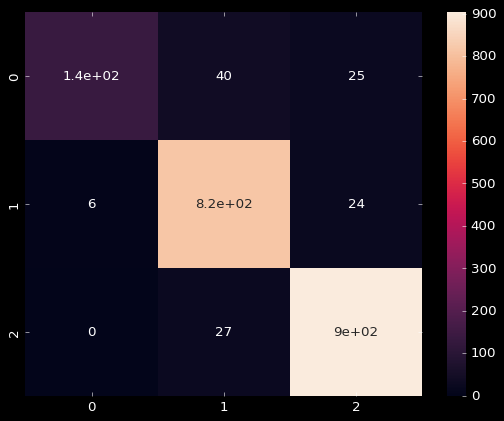

In [45]:
cm = confusion_matrix(test_labels, prediction_RF)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 20ms/step
The prediction for this image is:  ['boats']
The actual label for this image is:  boats


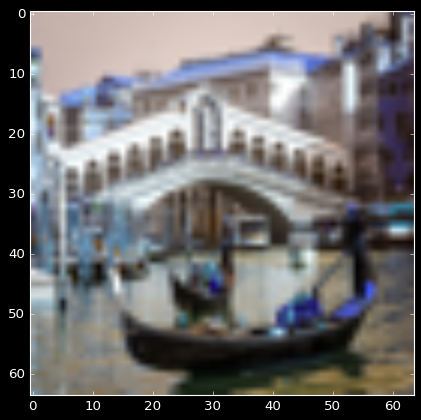

In [46]:
# Checking results on a few select images
# RF works much worse than CNN
n=7 # Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) # Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = rf.predict(input_img_features)[0] 
prediction_RF = LE.inverse_transform([prediction_RF])  # Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

# Attempt to predict the images in a Captcha

In [47]:
dir_ = Path('captcha_f')
filepaths = list(dir_.glob(r'*'))

filepaths = pd.Series(filepaths, name = 'File').astype(str)

df_c = pd.concat([filepaths], axis=1)

labels = ['boats', 'non-vehicles', 'non-vehicles', 'non-vehicles', 'boats', 'vehicles', 
         'vehicles', 'non-vehicles', 'non-vehicles']

df_c['Label'] = labels

df_c_labels = LE.fit_transform(df_c['Label'])


print("Preparing the test dataset ...")
c_test_set = test_datagen.flow_from_dataframe(
    dataframe = df_c,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Preparing the test dataset ...
Found 9 validated image filenames belonging to 3 classes.


1/1 [==============================] - 0s 91ms/step


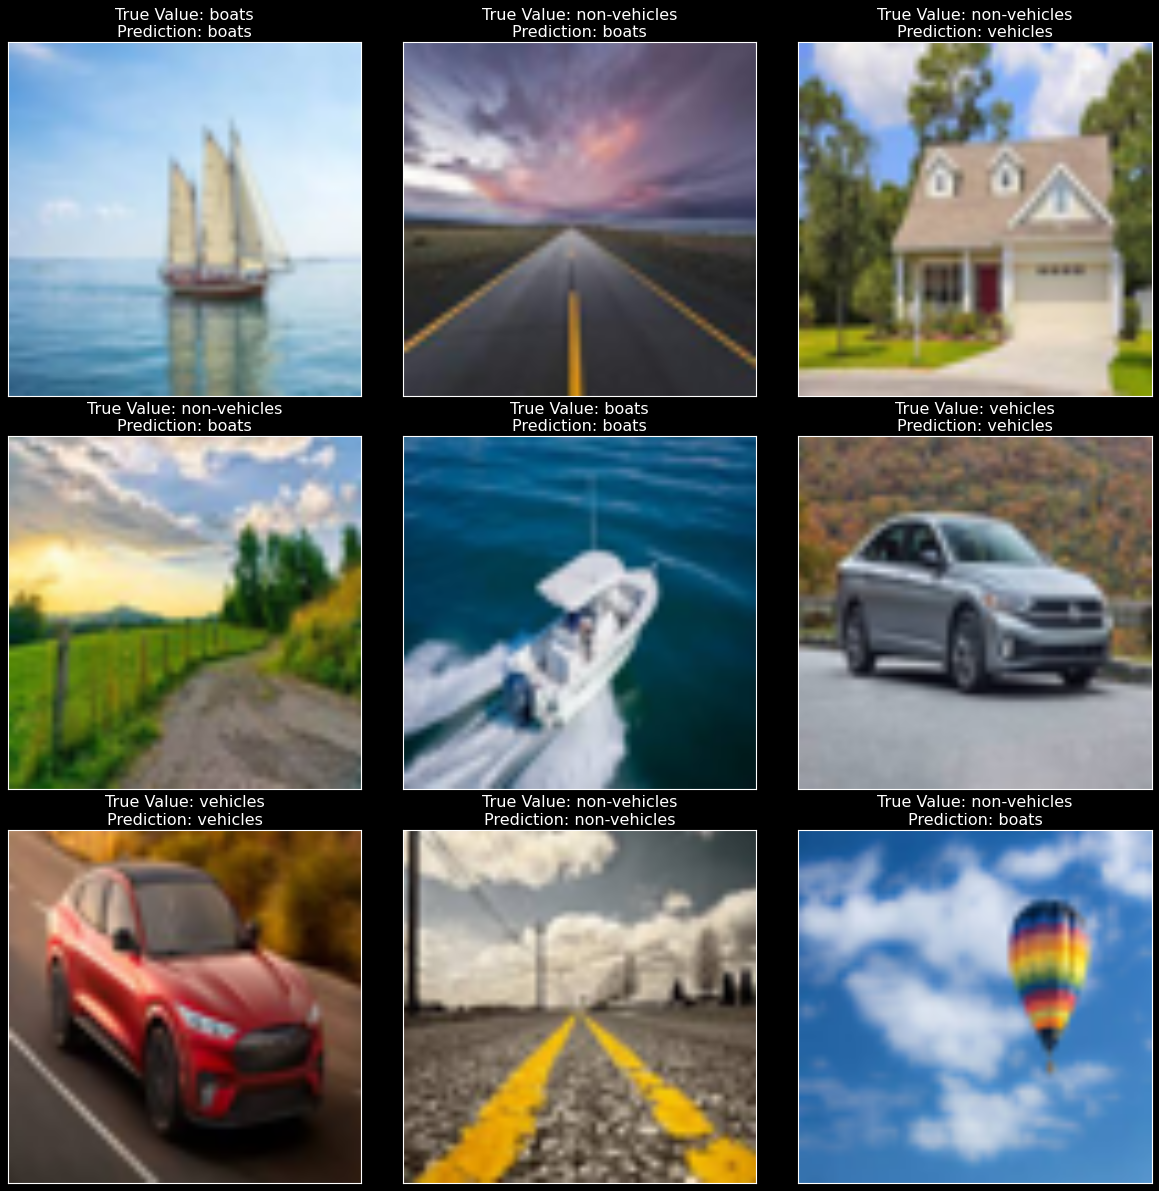

In [51]:
captcha_pred = CNN_inc.predict(c_test_set)

fig, axes = plt.subplots(nrows = 3,
                         ncols = 3,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_c["File"].iloc[i]))
    
    
    largest = 0
    val = captcha_pred[i][0]
    
    if captcha_pred[i][1] > val:
        val = captcha_pred[i][1]
        largest = 1
    if captcha_pred[i][2] > val:
        val = captcha_pred[i][2]
        largest = 2
        
    if largest == 0:
        output = "boats"
    elif largest == 1:
        output = "non-vehicles"
    elif largest == 2:
        output = "vehicles"
    else: 
        print("Error")
        
        
    ax.set_title(f"True Value: {df_c.Label.iloc[i]}\nPrediction: {output}")
plt.tight_layout()
plt.show()

### As you can see in the image below, the model only correctly classified five of the nine images. It is worth noting that the model had 100 percent accuracy with vehicles and boats, but struggled to classify images with neither vehicles nor boats in them. 

### The ninth image, which featured a hot air balloon floating in a blue sky, was intentionally included to challenge the model. As expected, a colorful object with a bright blue background was classified as a boat. This was foreshadowed by the scatter plot displayed earlier. The model would likely need much more training data, or perhaps a new class of flying vehicles, before it can defeat a Captcha test.